# Step 1:Import packages


In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install tensorflow-model-optimization

  Using cached https://files.pythonhosted.org/packages/55/38/4fd48ea1bfcb0b6e36d949025200426fe9c3a8bfae029f0973d85518fa5a/tensorflow_model_optimization-0.5.0-py2.py3-none-any.whl


In [ ]:
 pip install -q tf-nightly

     |████████████████████████████████| 454.4MB 24kB/s 
     |████████████████████████████████| 471kB 38.6MB/s 
     |████████████████████████████████| 1.3MB 39.3MB/s 
     |████████████████████████████████| 5.9MB 36.9MB/s 
     |████████████████████████████████| 4.2MB 38.9MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021052700 which is incompatible.


In [ ]:
import os
import glob
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from keras.layers import LSTM
from numpy import array
from numpy import hstack
#from keras.callbacks import EarlyStopping
#from keras.optimizers import RMSprop
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import sample
import tempfile
import tensorflow_model_optimization as tfmot

In [ ]:
print(tf.__version__) 
tf.test.gpu_device_name()

2.5.0


'/device:GPU:0'

# Step 2:Mount Google drive

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/drive


In [ ]:
os.listdir()

['driver_pt.ipynb',
 'Keras_model',
 'TFLite_model',
 'training_model',
 'train_data',
 'driver_tf.ipynb']

# Step 3:Demo CSV files from drive
only for testing

['16.CSV', '18.CSV', '19.CSV', '20.CSV', '17.CSV', '22.CSV', '1.CSV', '2.CSV', '4.CSV', '3.CSV', '7.CSV', '6.CSV', '10.CSV', '8.CSV', '11.CSV', '12.CSV', '13.CSV', '14.CSV', '15.CSV']


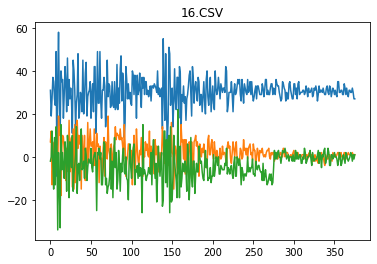

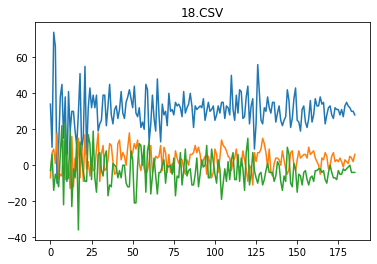

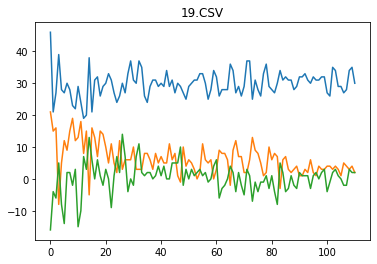

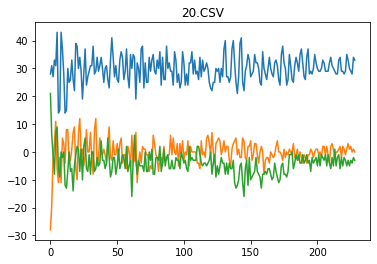

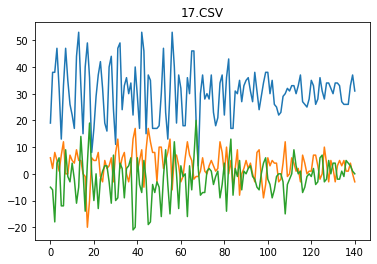

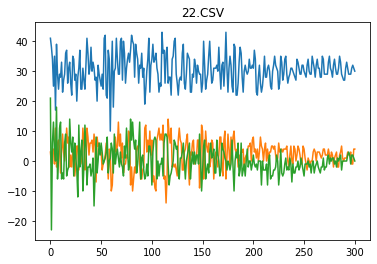

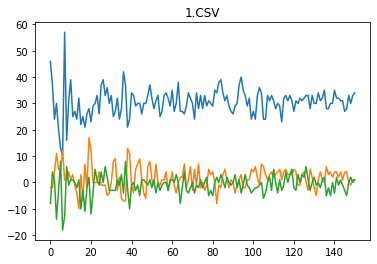

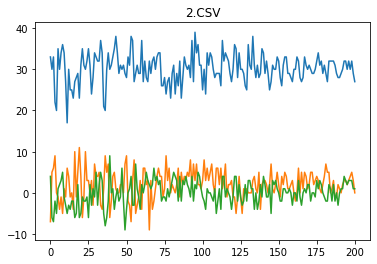

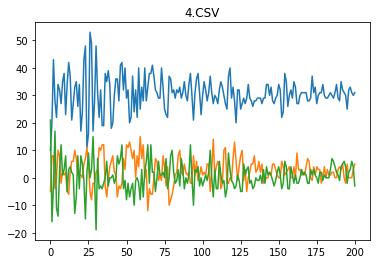

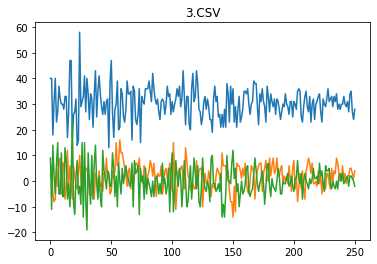

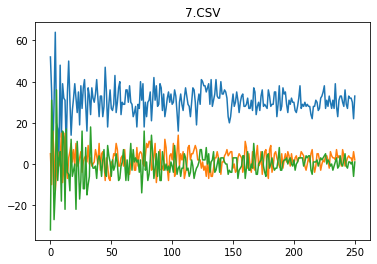

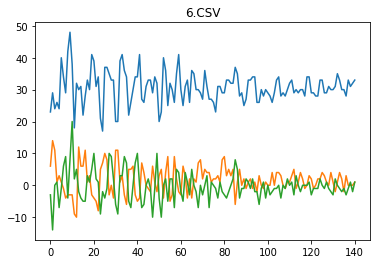

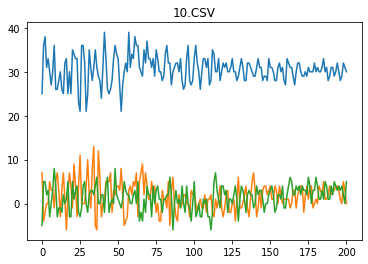

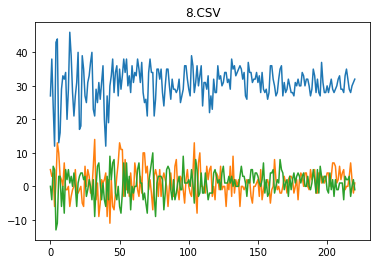

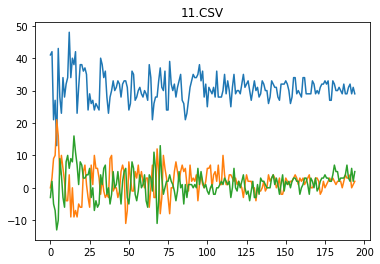

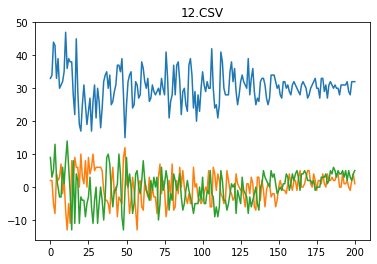

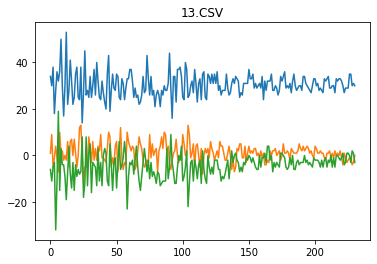

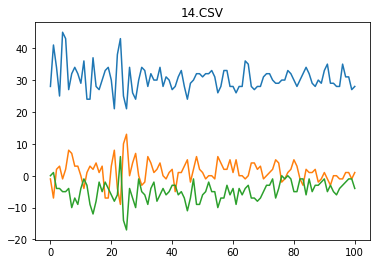

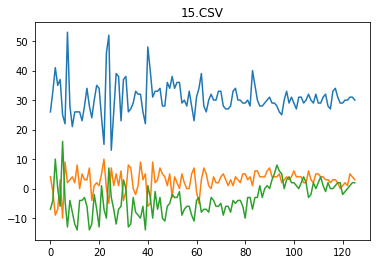

In [ ]:
# testing
# 0_idle
# 1_cruise
# 2_start
# 3_stop
# 4_left
# 5_right
demo_path = ('/content/drive/My Drive/Colab Notebooks/train_data/3_stop/')
print(os.listdir(demo_path))
for i in range(len(os.listdir(demo_path))):
  demo_file = os.listdir(demo_path)[i]
  demo_data = pd.read_csv(demo_path + demo_file)
  # testing
  ax = demo_data['ax'].to_numpy()
  ay = demo_data['ay'].to_numpy()
  az = demo_data['az'].to_numpy()
  # testing
  plt.figure()
  plt.plot(ax, label = 'ax')
  plt.plot(ay, label = 'ay')
  plt.plot(az, label = 'az')
  plt.title(demo_file)
  plt.show()

# Step 4:Data preprocessing for CNN input
1. Load CSV file from drive and then split the input data to sequences

2. Concatenate all training sequences and shuffle

Split input data to sequences

In [ ]:
def read_file(file_path, file_name, motion_category):
    read_data = pd.read_csv(file_path + file_name)
    ax = read_data['ax'].to_numpy()
    ay = read_data['ay'].to_numpy()
    az = read_data['az'].to_numpy()
    acc = hstack((ax.reshape(-1, 1), ay.reshape(-1, 1), az.reshape(-1, 1)))
    m_onehot = np.eye(4)[motion_category] ###
    m = []
    for i in range(ax.shape[0]):
      m.append(m_onehot)
    motion = array(m)
    dataset = hstack((acc, motion))
    return dataset

In [ ]:
#Multiple Parallel Series
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :3], sequences[end_ix, 3:]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Load CSV file and split data

In [ ]:
def create_seq(file_path, motion_category, n_steps, test_size):
  all_files = os.listdir(file_path)
  file_num = len(all_files)
  test_num = int(file_num * test_size)
  test_files = sample(all_files, test_num)
  train_files = list(set(all_files) - set(test_files))

  X_train = np.empty((0,n_steps,3))
  y_train = np.empty((0,4)) ###
  X_test = np.empty((0,n_steps,3))
  y_test = np.empty((0,4))  ### 

  for i in range(len(train_files)):  
    train_file_name = train_files[i]
    train_dataset = read_file(file_path, train_file_name, motion_category)
    Xi, yi = split_sequences(train_dataset, n_steps)
    X_train = np.concatenate((X_train, Xi))
    y_train = np.concatenate((y_train, yi))

  for j in range(len(test_files)):  
    test_file_name = test_files[j]
    test_dataset = read_file(file_path, test_file_name, motion_category)
    Xj, yj = split_sequences(test_dataset, n_steps)
    X_test = np.concatenate((X_test, Xj))
    y_test = np.concatenate((y_test, yj))

  return X_train, y_train, X_test, y_test

Define some important elements

In [ ]:
n_features = 3 # ax, ay, az
n_class = 4    # start, stop
n_steps = 30   # 

Preprocess the data

In [ ]:
idle_path = '/content/drive/My Drive/Colab Notebooks/train_data/0_idle/'
X_idle_train, y_idle_train,X_idle_test,y_idle_test  = create_seq(idle_path ,0 ,n_steps, 0.2) 

cruise_path = '/content/drive/My Drive/Colab Notebooks/train_data/1_cruise/'
X_cruise_train, y_cruise_train,X_cruise_test,y_cruise_test  = create_seq(cruise_path ,1 ,n_steps, 0.2) 

start_path = '/content/drive/My Drive/Colab Notebooks/train_data/2_start/'
X_start_train, y_start_train, X_start_test, y_start_test = create_seq(start_path, 2, n_steps, 0.2)

stop_path = '/content/drive/My Drive/Colab Notebooks/train_data/3_stop/'
X_stop_train, y_stop_train, X_stop_test, y_stop_test  = create_seq(stop_path, 3, n_steps, 0.2) 

#left_path = '/content/drive/My Drive/Colab Notebooks/train_data/4_left/'
#X_left_train, y_left_train, X_left_test, y_left_test  = creat_seq(left_path, 4, n_steps, 0.2) 

#right_path = '/content/drive/My Drive/Colab Notebooks/train_data/5_right/'
#X_right_train, y_right_train, X_right_test, y_right_test  = creat_seq(right_path, 4, n_steps, 0.2) 

Concatenate and shuffle **training** data

In [ ]:
# concatenate all class of input
X1 = np.concatenate(
    (X_idle_train, X_cruise_train, X_start_train, X_stop_train))
y1 = np.concatenate(
    (y_idle_train, y_cruise_train, y_start_train, y_stop_train))

# Shuffle the data
X_train, y_train = shuffle(X1, y1, random_state = 0)
print(X_train.shape)
print(y_train.shape)
X_train = np.expand_dims(X_train, axis=-1)

(17132, 30, 3)
(17132, 4)


Concatenate and shuffle **testing** data

In [ ]:
# concatenate all class of input
X2 = np.concatenate(
    (X_idle_test, X_cruise_test, X_start_test, X_stop_test))
y2 = np.concatenate(
    (y_idle_test, y_cruise_test, y_start_test, y_stop_test))

# Shuffle the data
X_test, y_test = shuffle(X2, y2, random_state = 0)
print(X_test.shape)
print(y_test.shape)
X_test = np.expand_dims(X_test, axis=-1)

(4317, 30, 3)
(4317, 4)


# Step 5:Build CNN model

In [ ]:
# define model
model = keras.Sequential([
  keras.layers.Conv2D(filters=10,kernel_size=(8,3),padding='same',activation='relu',input_shape=(n_steps,3,1)),
  keras.layers.MaxPool2D((3, 3), padding='same'),
  keras.layers.Dropout(0.1),
  keras.layers.Conv2D(20, (4, 1), padding="same",activation="relu"),
  keras.layers.MaxPool2D((3, 1), padding="same"),
  keras.layers.Dropout(0.1),
  keras.layers.Flatten(),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(n_class, activation='softmax', name='Classifier')
])

model.summary()
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 3, 10)         250       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 1, 10)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 1, 10)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 1, 20)         820       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 1, 20)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 1, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)               

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model
model = quantize_model(model)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 30, 3, 1)          3         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 30, 3, 10)         273       
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 10, 1, 10)         1         
_________________________________________________________________
quant_dropout_2 (QuantizeWra (None, 10, 1, 10)         1         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 10, 1, 20)         863       
_________________________________________________________________
quant_max_pooling2d_3 (Quant (None, 4, 1, 20)          1         
_________________________________________________________________
quant_dropout_3 (QuantizeWra (None, 4, 1, 20)         

# Step 6:Train CNN model

In [ ]:
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto',restore_best_weights=True)
# lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
file_path = '/content/drive/My Drive/Colab Notebooks/training_model/{epoch:02d}-pnn_May28_nsteps-30_vloss-{val_loss:.4f}_vacc-{val_accuracy:.4f}.h5'
check_pt = keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=True)
history = model.fit(X_train, y_train, epochs=200, batch_size = 10000, validation_data = (X_test,y_test),verbose=1,callbacks=check_pt)

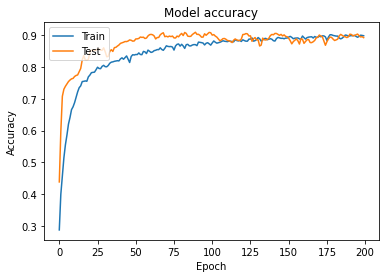

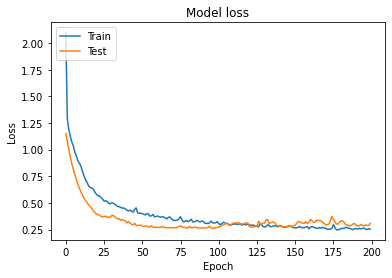

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Step 7:Save and load keras model in h5 format

Install the required thing

In [ ]:
!pip install pyyaml h5py

Naming the model and file path

In [ ]:
model_name = 'pnn_May28_nsteps-30_vloss-0.2614_vacc-0.9041'

In [ ]:
Keras_h5_path = 'Keras_model/' + model_name + '.h5' 
Keras_tf_path = 'Keras_model/' + model_name + '.tf' 

Save Keras model in h5 format

In [ ]:
model.save(Keras_h5_path)

Save Keras model in tf format

In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE, 1], model.inputs[0].dtype))
model.save(Keras_tf_path, signatures=concrete_func)

INFO:tensorflow:Assets written to: Keras_model/pnn_May28_nsteps-30_vloss-0.2614_vacc-0.9041.tf/assets


INFO:tensorflow:Assets written to: Keras_model/pnn_May28_nsteps-30_vloss-0.2614_vacc-0.9041.tf/assets


Load the Keras model in drive and summary

In [ ]:
load_model_tf = tf.keras.models.load_model(Keras_tf_path)
load_model_tf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 30, 3, 1)          3         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 30, 3, 10)         273       
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 10, 1, 10)         1         
_________________________________________________________________
quant_dropout_2 (QuantizeWra (None, 10, 1, 10)         1         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 10, 1, 20)         863       
_________________________________________________________________
quant_max_pooling2d_3 (Quant (None, 4, 1, 20)          1         
_________________________________________________________________
quant_dropout_3 (QuantizeWra (None, 4, 1, 20)         

In [ ]:
model = load_model_tf

In [ ]:
with tfmot.quantization.keras.quantize_scope():
  load_model_h5 = tf.keras.models.load_model(Keras_h5_path)
load_model_h5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 30, 3, 1)          3         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 30, 3, 10)         273       
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 10, 1, 10)         1         
_________________________________________________________________
quant_dropout_2 (QuantizeWra (None, 10, 1, 10)         1         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 10, 1, 20)         863       
_________________________________________________________________
quant_max_pooling2d_3 (Quant (None, 4, 1, 20)          1         
_________________________________________________________________
quant_dropout_3 (QuantizeWra (None, 4, 1, 20)         

In [ ]:
model = load_model_h5

# Step 8:Coverting the Keras model to TensorFlowLite model and save

In [ ]:
TFLite_path = 'TFLite_model/' + model_name + '.tflite'

In [ ]:
X_train_f32 = tf.cast(X_train, tf.float32)
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train_f32).batch(1).take(100):
    yield [input_value]


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(Keras_tf_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
TFLite_model = converter.convert()

In [ ]:
open(TFLite_path, "wb").write(TFLite_model)
print("TFLite models and their sizes:")
!ls "TFLite_model" -lh

TFLite models and their sizes:
total 10K
-rw------- 1 root root 9.9K May 28 16:14 pnn_May28_nsteps-30_vloss-0.2614_vacc-0.9041.tflite


# Step 9:TFLite model quantization

Show details of TFLite model

In [ ]:
TFLite_interpreter = tf.lite.Interpreter(model_path=TFLite_path)

input_details = TFLite_interpreter.get_input_details()
output_details = TFLite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_x:0
shape: [ 1 30  3  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 4]
type: <class 'numpy.int8'>


Resize input and output tensor shape of TFLite model

In [ ]:
TFLite_interpreter.resize_tensor_input(input_details[0]['index'], (1, n_steps, 3, 1))
TFLite_interpreter.resize_tensor_input(output_details[0]['index'], (1,4))
TFLite_interpreter.allocate_tensors()

input_details = TFLite_interpreter.get_input_details()
output_details = TFLite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
input_scale = input_details[0]['quantization'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
print(input_scale, input_zero_point)
output_scale = output_details[0]['quantization'][0]
output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
print(output_scale, output_zero_point)

== Input details ==
name: serving_default_x:0
shape: [ 1 30  3  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 4]
type: <class 'numpy.int8'>
0.8666666746139526 -20
0.00390625 -128


# Step 9:Verify the quantized model

In [ ]:
prediction = model.predict([X_test[:100]])

In [1]:
same = 0
correct = 0
cc = 0
np.set_printoptions(precision=3, suppress=True)
for i in range(100):
  TFLite_interpreter.set_tensor(input_details[0]['index'], ([(((X_test[i])/input_scale)+input_zero_point).astype('int8')]))
  TFLite_interpreter.invoke()
  TFLite_model_predictions = TFLite_interpreter.get_tensor(output_details[0]['index'])
  if np.argmax((TFLite_model_predictions[0]-output_zero_point )*output_scale) == np.argmax(prediction[i]):
    same = same + 1
  if np.argmax((TFLite_model_predictions[0]-output_zero_point)*out_scale) == np.argmax(y_test[i]):
    correct = correct + 1
  if np.argmax(prediction[i]) == np.argmax(y_test[i]):
    cc = cc + 1
  print(y_test[i], '\t',(TFLite_model_predictions[0]+128)*0.00390625,'\t', prediction[i])
print(same)
print(correct)
print(cc)

NameError: ignored